In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def swift_voce(strain, alpha, A, epsilon_0, n, k0, Q, beta):
        swift_term = alpha * A * (epsilon_0 + strain) ** n
        voce_term = (1 - alpha) * (k0 + Q * (1 - np.exp(-beta * strain)))
        return swift_term + voce_term


def modified_swift_voce(strain, A, B, n, Q, epsilon0, alpha, beta):
        swift_part = A * (strain + epsilon0) ** n  # Swift law
        voce_part = Q * (1 - np.exp(-B * strain))  # Voce law
        damping = (1 - np.exp(-alpha * strain)) / (1 + beta * strain)  # Damping term
        return swift_part + voce_part * damping

# Normal Swift-Voce fitting

In [7]:
def analyze_sv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
# Load data in
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values
    
# Initial guesses for parameters [alpha, A, epsilon_0, n, k0, Q, beta]
    initial_guess = [0.5, 500, 0.01, 0.2, 300, 200, 10]

# Fit the curve
    params, _ = curve_fit(swift_voce, strain, stress, p0=initial_guess, maxfev=100000)
    
# Extract fitted parameters
    alpha, A, epsilon_0, n, k0, Q, beta = params

# Plot the experimental data and the fitted curve
    fitted_stress = swift_voce(strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(strain, fitted_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend()
    plt.show()

# Print fitted parameters
    print(f'Fitted Parameters:\nAlpha: {alpha:.4f}\nA: {A:.4f}\nEpsilon_0: {epsilon_0:.4f}\n'
      f'n: {n:.4f}\nK0: {k0:.4f}\nQ: {Q:.4f}\nBeta: {beta:.4f}\n')
    
# Calculate error metrics
    mse = np.mean((stress - fitted_stress) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(stress - fitted_stress))
    r_squared = 1 - np.sum((stress - fitted_stress) ** 2) / np.sum((stress - np.mean(stress)) ** 2)

    # Print error metrics
    print(f'Error Metrics:\n'
          f'MSE: {mse:.4f}\n'
          f'RMSE: {rmse:.4f}\n'
          f'MAE: {mae:.4f}\n'
          f'R-squared: {r_squared:.4f}')
    
# Extended strain for comparison (you might want to adjust this range)
    extended_strain = np.concatenate((strain, np.arange(strain[-1] + 0.01, 2.01, 0.01)))
    extended_stress = swift_voce(extended_strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend()
    plt.show()
    
    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'Strain': extended_strain,
        'Stress': extended_stress
    })

    # Save the DataFrame to a CSV file
    output_file_path = f"extended_curve/{title}"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)

    '''
    # Export stress and strain values
    stress_difference = stress - fitted_stress
    
    # Create a DataFrame with the required columns
    df = pd.DataFrame({
        'Experimental Strain': strain,
        'Experimental Stress': stress,
        'Fitted Stress': fitted_stress,
        'Stress Difference': stress_difference
    })
    extracted_strain = np.arange(0.1, 3.01, 0.01)
    extracted_stress = swift_voce(extracted_strain, *params)
    df2 = pd.DataFrame({
        'Extended Strain': extracted_strain,
        'Extended Stress': extracted_stress,
    })

    # Save the DataFrame to an Excel file with the file name based on the `title` argument
    output_file_path = f"{title}_stress_strain_comparison.xlsx"
    with pd.ExcelWriter(output_file_path) as writer:
        df.to_excel(writer, sheet_name='Comparison', index=False)
        df2.to_excel(writer, sheet_name='Extended Fit', index=False)
    
    print(f"Data has been exported to {output_file_path}")
    '''
    return params, extended_stress, extended_strain
   

# Modified Swift-Voce fitting with damping value for high strain

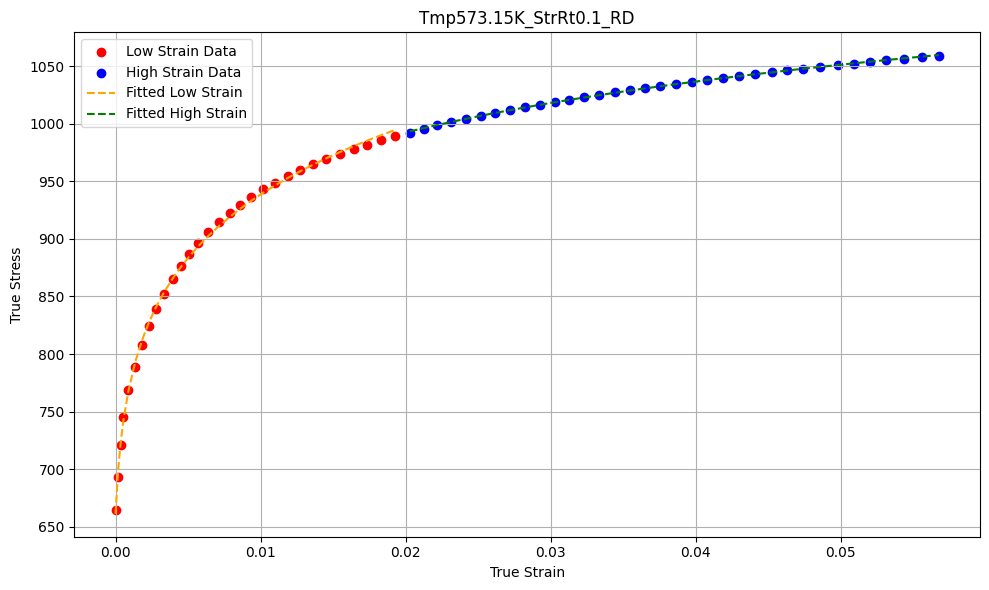

Fitted Parameters for Low Strain (<0.02):
A: 1415.9329, B: 0.2500, n: 0.0897, Q: 1858.7673, Epsilon_0: 0.0002, Alpha: 0.0000, Beta: 19.5192
Fitted Parameters for High Strain (>=0.02):
A: 1268.9145, B: 22.3949, n: 0.0628, Q: 3383.1684, Epsilon_0: 0.0000, Alpha: 0.0000, Beta: 2.4493


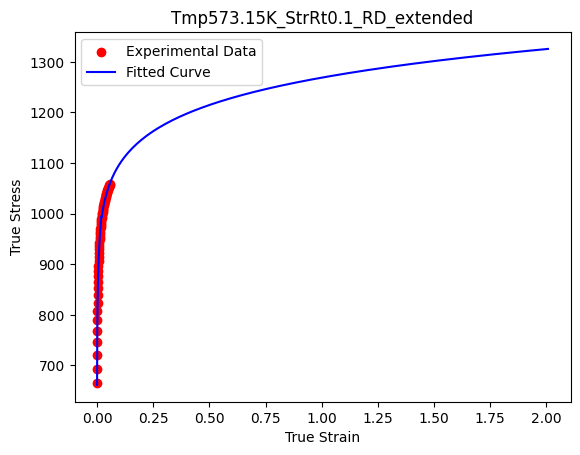

(array([1.41593288e+03, 2.50000000e-01, 8.96971058e-02, 1.85876732e+03,
        2.06233504e-04, 1.52647993e-09, 1.95191899e+01]),
 array([1.26891452e+03, 2.23948692e+01, 6.28398337e-02, 3.38316838e+03,
        1.00295450e-17, 7.12469427e-21, 2.44932860e+00]))

In [13]:
def analyze_msv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
    # Load data
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values
    
    # Initial guesses for parameters [A, B, n, K, epsilon0, alpha, beta]
    if initial_guess is None:
        initial_guess = [1500, 20, 0.2, 2000, 0.02, 0.3, 5] # Default values if not provided
    
    # Adjusted bounds to limit parameter values
    bounds = ([500, 0, 0, 500, 0, 0, 0], [5000, 50, 1, 5000, 0.2, 1, 20])

    # Separate data into low and high strain regions
    low_strain = strain[strain < 0.02]
    low_stress = stress[strain < 0.02]

    high_strain = strain[strain >= 0.02]
    high_stress = stress[strain >= 0.02]

    # Fit the curve for low strain data
    params_low, _ = curve_fit(
        modified_swift_voce, low_strain, low_stress, p0=initial_guess, bounds=bounds
    )

    # Fit the curve for high strain data
    params_high, _ = curve_fit(
        modified_swift_voce, high_strain, high_stress, p0=initial_guess, bounds=bounds
    )

    # Extract fitted stress values
    fitted_low_stress = modified_swift_voce(low_strain, *params_low)
    fitted_high_stress = modified_swift_voce(high_strain, *params_high)

    # Plot experimental and fitted curves
    plt.figure(figsize=(10, 6))
    plt.scatter(low_strain, low_stress, label='Low Strain Data', color='red')
    plt.scatter(high_strain, high_stress, label='High Strain Data', color='blue')
    plt.plot(low_strain, fitted_low_stress, color='orange', linestyle='--', label='Fitted Low Strain')
    plt.plot(high_strain, fitted_high_stress, color='green', linestyle='--', label='Fitted High Strain')
    
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print fitted parameters for both regions
    print(f'Fitted Parameters for Low Strain (<0.02):\n'
          f'A: {params_low[0]:.4f}, B: {params_low[1]:.4f}, n: {params_low[2]:.4f}, '
          f'Q: {params_low[3]:.4f}, Epsilon_0: {params_low[4]:.4f}, '
          f'Alpha: {params_low[5]:.4f}, Beta: {params_low[6]:.4f}')

    print(f'Fitted Parameters for High Strain (>=0.02):\n'
          f'A: {params_high[0]:.4f}, B: {params_high[1]:.4f}, n: {params_high[2]:.4f}, '
          f'Q: {params_high[3]:.4f}, Epsilon_0: {params_high[4]:.4f}, '
          f'Alpha: {params_high[5]:.4f}, Beta: {params_high[6]:.4f}')

    extended_strain = np.concatenate((strain, np.arange(strain[-1] + 0.01, 2.01, 0.01)))
    low_stress = modified_swift_voce(extended_strain[extended_strain < 0.02], *params_low)
    high_stress = modified_swift_voce(extended_strain[extended_strain >= 0.02], *params_high)
    extended_stress = np.concatenate((low_stress, high_stress))
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend()
    plt.show()

    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'Strain': extended_strain,
        'Stress': extended_stress
    })

    # Save the DataFrame to a CSV file
    output_file_path = f"extended_curve/{title}"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)
    return params_low, params_high

condition = 'Tmp298.15K_StrRt1_RD'
#condition = 'Tmp473.15K_StrRt0.1_RD'
analyze_msv_fit('data/Exp_FC_StrRtDpn_TmpDpn_Tmp298.csv', condition + '_E', condition + '_S', condition)


# Plot of all strain rate and parameters relationship

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


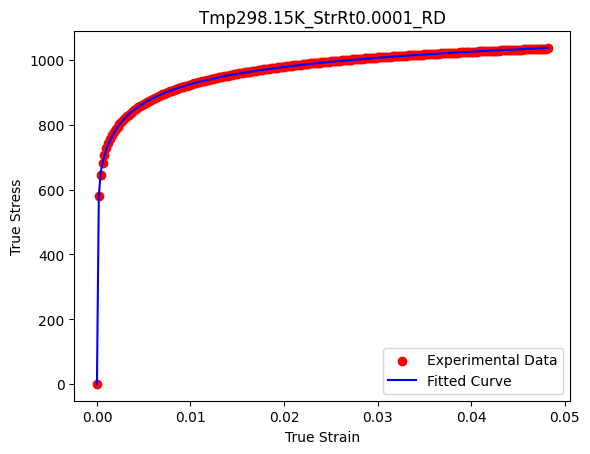

Fitted Parameters:
Alpha: -0.0843
A: 1855.4915
Epsilon_0: 0.0005
n: -0.2100
K0: 699.9021
Q: 528.6419
Beta: 12990.0817

Error Metrics:
MSE: 1.8040
RMSE: 1.3431
MAE: 1.0403
R-squared: 0.9998


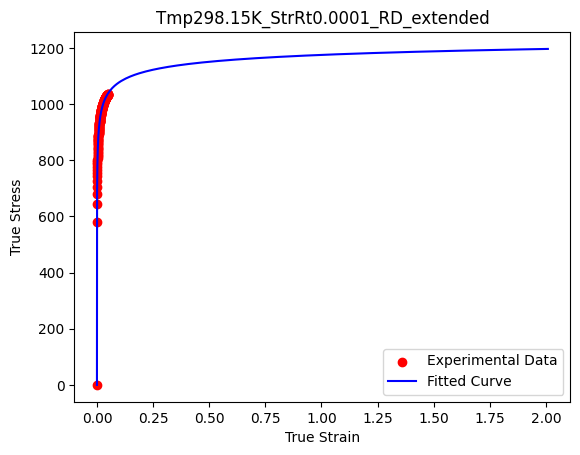

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


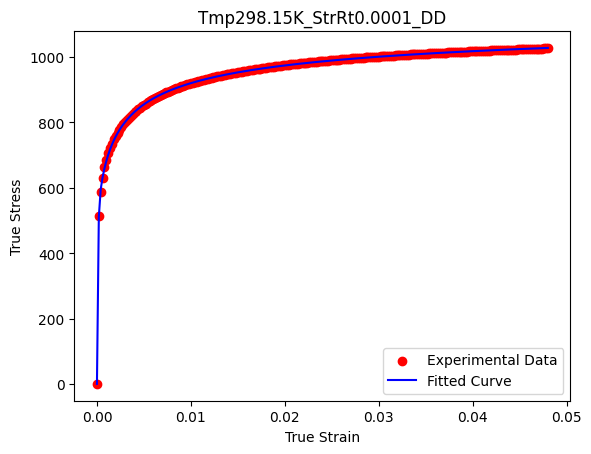

Fitted Parameters:
Alpha: -0.0351
A: 1449.0665
Epsilon_0: 0.0007
n: -0.3575
K0: 654.2613
Q: 482.9348
Beta: 11932.3490

Error Metrics:
MSE: 1.3216
RMSE: 1.1496
MAE: 0.7950
R-squared: 0.9999


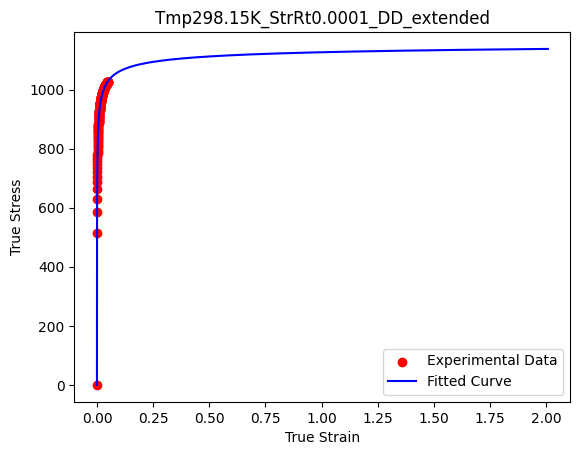

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


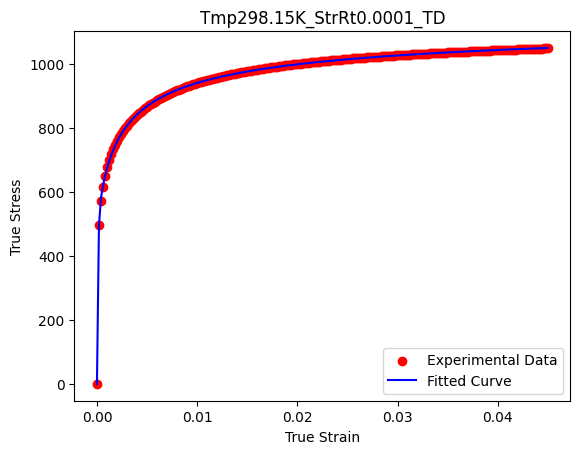

Fitted Parameters:
Alpha: -0.0162
A: 1859.3901
Epsilon_0: 0.0010
n: -0.4505
K0: 670.9988
Q: 480.5649
Beta: 11558.5423

Error Metrics:
MSE: 1.7418
RMSE: 1.3198
MAE: 0.9458
R-squared: 0.9999


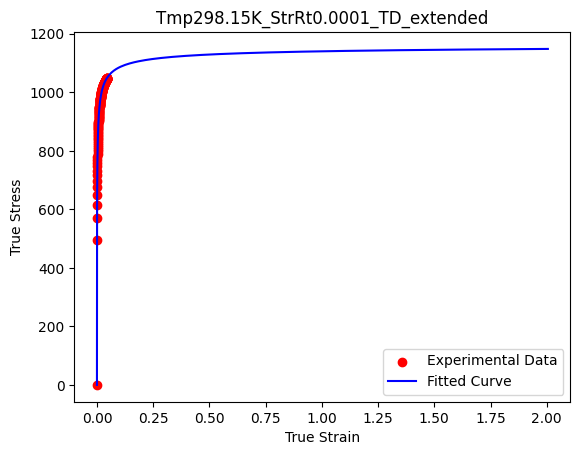

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


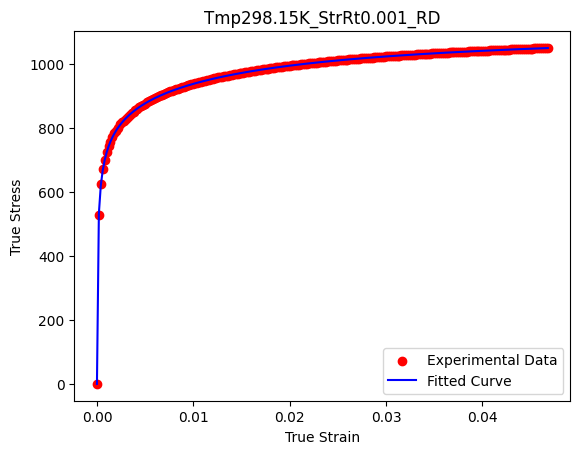

Fitted Parameters:
Alpha: -0.1499
A: 829.4386
Epsilon_0: 0.0000
n: -0.2021
K0: 1059.8279
Q: 54.5216
Beta: 76.6431

Error Metrics:
MSE: 0.2956
RMSE: 0.5437
MAE: 0.2610
R-squared: 1.0000


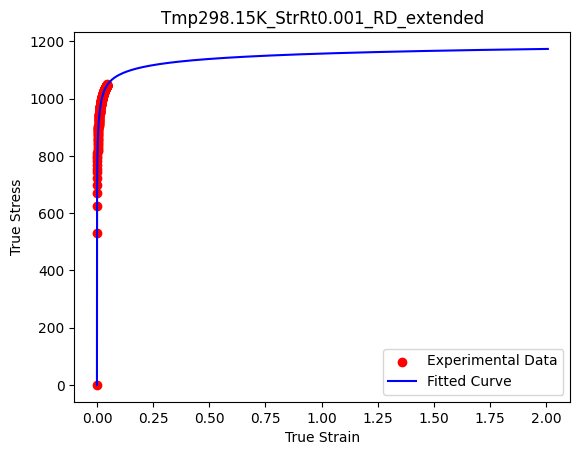

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


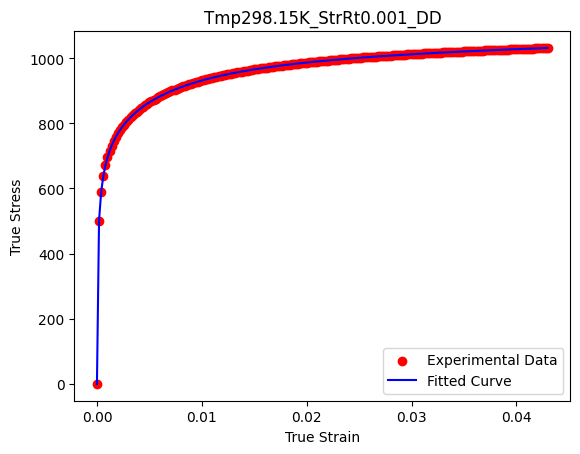

Fitted Parameters:
Alpha: -0.1696
A: 896.9352
Epsilon_0: 0.0000
n: -0.1862
K0: 1054.5637
Q: 61.0253
Beta: 156.4644

Error Metrics:
MSE: 0.0724
RMSE: 0.2691
MAE: 0.2127
R-squared: 1.0000


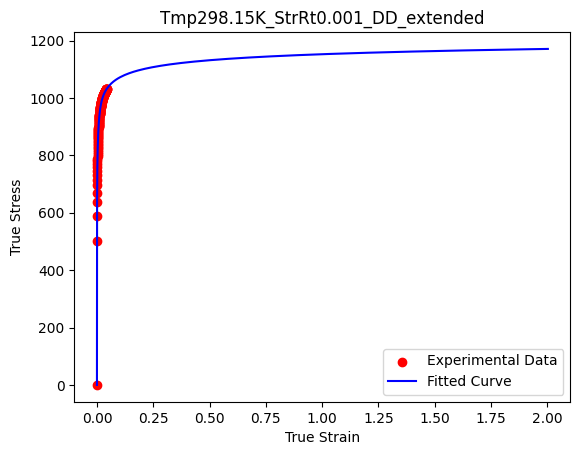

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


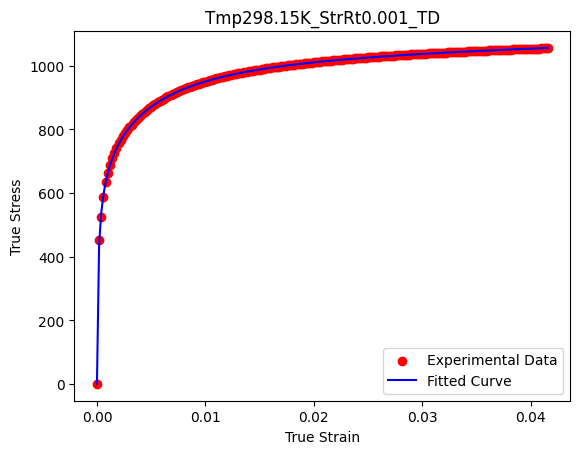

Fitted Parameters:
Alpha: -0.1573
A: 898.7127
Epsilon_0: 0.0000
n: -0.2040
K0: 1053.6354
Q: 92.6702
Beta: 201.5890

Error Metrics:
MSE: 2.3568
RMSE: 1.5352
MAE: 0.5065
R-squared: 0.9998


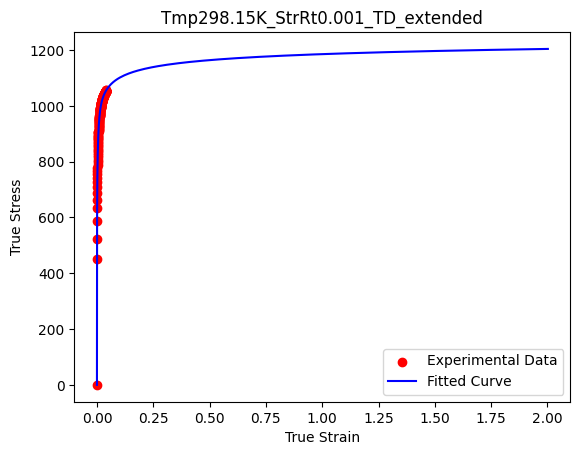

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


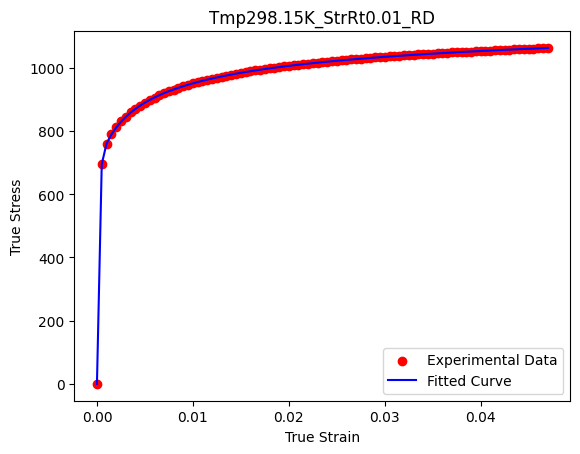

Fitted Parameters:
Alpha: -0.0412
A: 1528.7965
Epsilon_0: 0.0017
n: -0.3426
K0: 538.6508
Q: 652.1925
Beta: 6113.3657

Error Metrics:
MSE: 0.2257
RMSE: 0.4751
MAE: 0.3518
R-squared: 1.0000


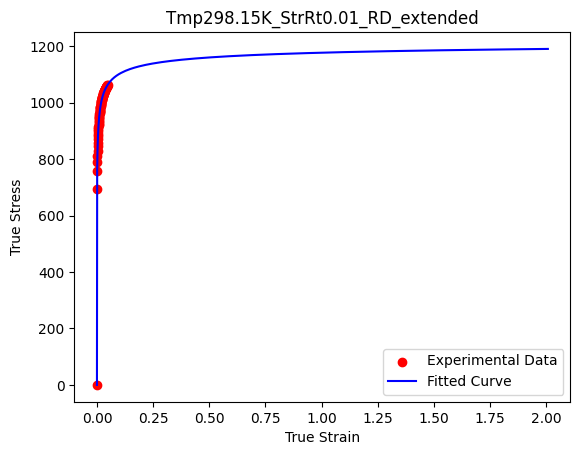

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


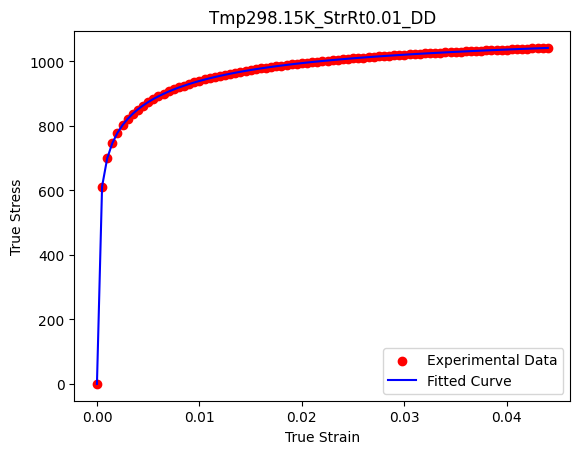

Fitted Parameters:
Alpha: -0.1439
A: 786.6893
Epsilon_0: 0.0000
n: -0.2221
K0: 1062.3852
Q: 46.3042
Beta: 130.3721

Error Metrics:
MSE: 0.2331
RMSE: 0.4828
MAE: 0.2647
R-squared: 1.0000


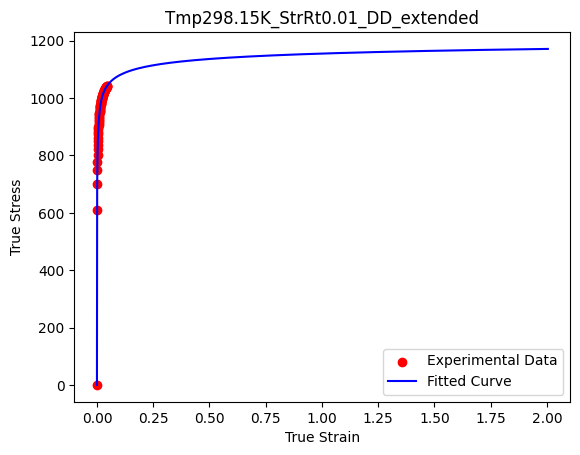

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


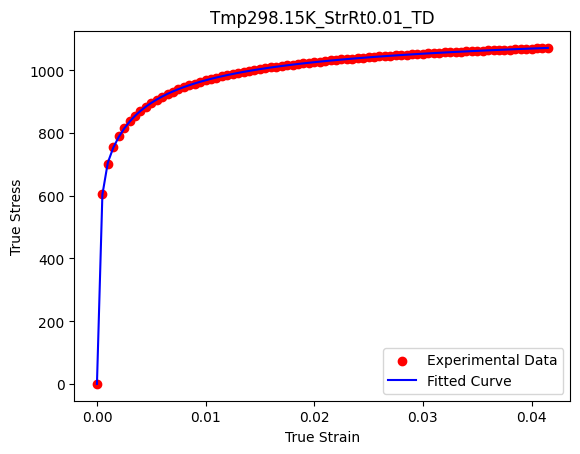

Fitted Parameters:
Alpha: -0.0142
A: 1595.8106
Epsilon_0: 0.0013
n: -0.4994
K0: 620.4402
Q: 543.5982
Beta: 5095.2831

Error Metrics:
MSE: 0.4123
RMSE: 0.6421
MAE: 0.4282
R-squared: 1.0000


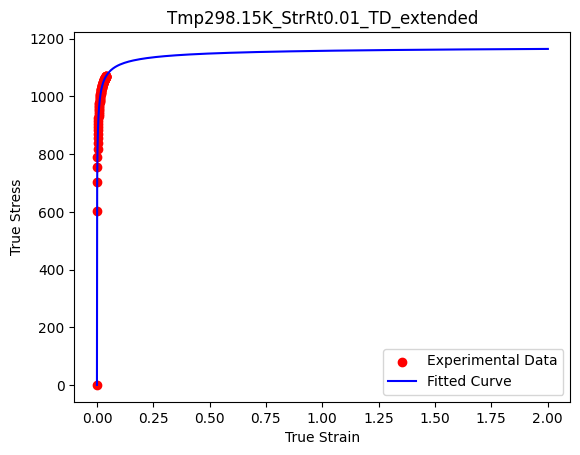

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


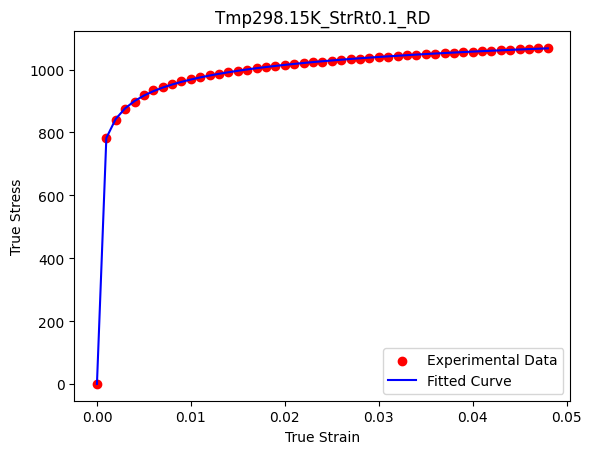

Fitted Parameters:
Alpha: -0.1833
A: 1344.1183
Epsilon_0: 0.0001
n: -0.1469
K0: 799.7405
Q: 427.7758
Beta: 12388.0087

Error Metrics:
MSE: 1.3047
RMSE: 1.1422
MAE: 0.9157
R-squared: 0.9999


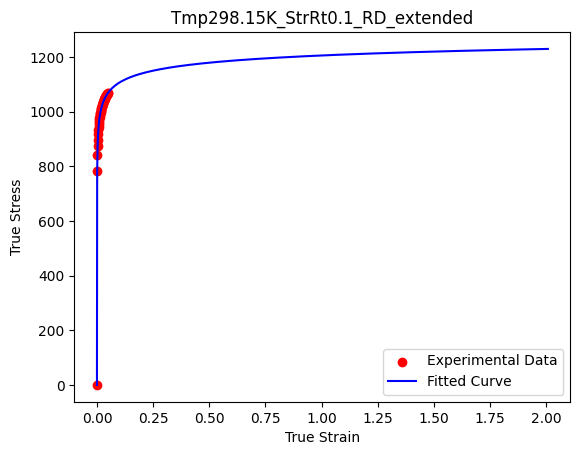

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


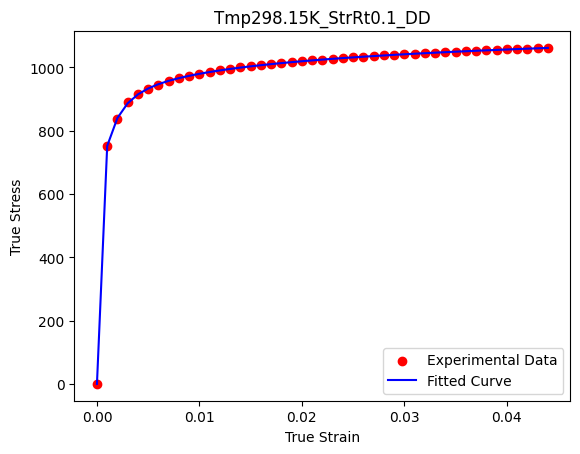

Fitted Parameters:
Alpha: -0.2393
A: 1821.1632
Epsilon_0: 0.0000
n: -0.0894
K0: 1192.5889
Q: 128.4945
Beta: 718.7260

Error Metrics:
MSE: 0.6722
RMSE: 0.8199
MAE: 0.3893
R-squared: 1.0000


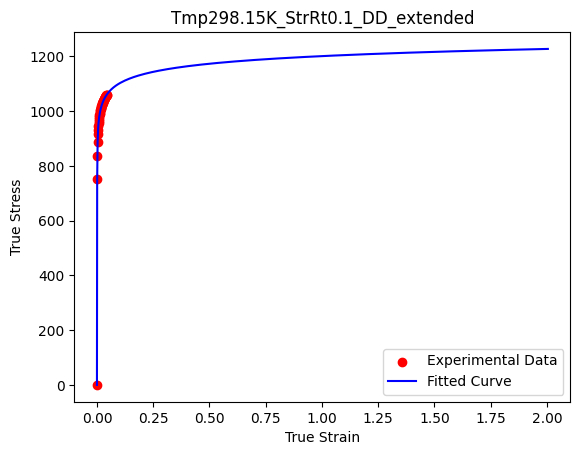

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


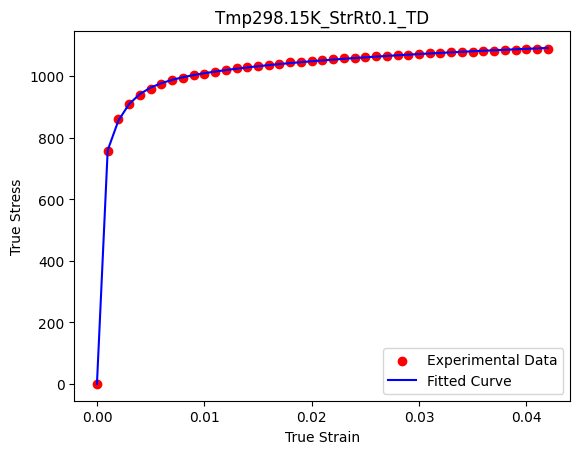

Fitted Parameters:
Alpha: 0.8197
A: 1290.7194
Epsilon_0: 0.0000
n: 0.0709
K0: -60.3743
Q: 1426.2732
Beta: 638.7484

Error Metrics:
MSE: 3.2585
RMSE: 1.8051
MAE: 1.4837
R-squared: 0.9999


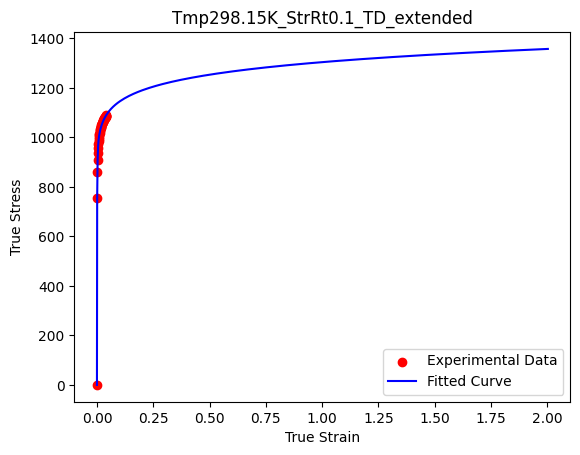

"\nfor i in range(7):\n    plt.figure(figsize=(8, 5))  # Create a new figure for each plot\n    plt.plot(conditions, [p[i] for p in params], marker='o')\n    plt.xlabel('Conditions')\n    plt.xticks(rotation=60)\n    plt.ylabel(params_name[i])\n    plt.title(params_name[i] + ' of Each Condition')\n    plt.tight_layout()  # Adjust layout to prevent label cut-off\n    plt.show()  # Display the plot\n"

In [19]:
params = [] #store all parameters
params_name  = ['alpha', 'A', 'epsilon_0', 'n', 'k0', 'Q', 'beta']

#conditions = ['Tmp77.15K_StrRt0.0001_RD']
#conditions = ['Tmp233.15K_StrRt0.0001_RD']
conditions = ['Tmp298.15K_StrRt0.0001_RD', 'Tmp298.15K_StrRt0.0001_DD', 'Tmp298.15K_StrRt0.0001_TD', 'Tmp298.15K_StrRt0.001_RD', 'Tmp298.15K_StrRt0.001_DD', 'Tmp298.15K_StrRt0.001_TD', 'Tmp298.15K_StrRt0.01_RD', 'Tmp298.15K_StrRt0.01_DD', 'Tmp298.15K_StrRt0.01_TD', 'Tmp298.15K_StrRt0.1_RD','Tmp298.15K_StrRt0.1_DD', 'Tmp298.15K_StrRt0.1_TD']
#conditions = ['Tmp373.15K_StrRt0.0001_RD', 'Tmp373.15K_StrRt0.001_RD', 'Tmp373.15K_StrRt0.01_RD', 'Tmp373.15K_StrRt0.1_RD']
#conditions = ['Tmp473.15K_StrRt0.0001_RD', 'Tmp473.15K_StrRt0.001_RD', 'Tmp473.15K_StrRt0.01_RD']
#conditions = ['Tmp573.15K_StrRt0.0001_RD', 'Tmp573.15K_StrRt0.001_RD', 'Tmp573.15K_StrRt0.01_RD', 'Tmp573.15K_StrRt0.1_RD']
#conditions = ['Tmp673.15K_StrRt0.0001_RD', 'Tmp673.15K_StrRt0.001_RD', 'Tmp673.15K_StrRt0.01_RD', 'Tmp673.15K_StrRt0.1_RD']

for condition in conditions:
    params.append(analyze_sv_fit('data/Exp_FC_StrRtDpn_TmpDpn_Tmp298.csv', condition + '_E', condition + '_S', condition))
'''
for i in range(7):
    plt.figure(figsize=(8, 5))  # Create a new figure for each plot
    plt.plot(conditions, [p[i] for p in params], marker='o')
    plt.xlabel('Conditions')
    plt.xticks(rotation=60)
    plt.ylabel(params_name[i])
    plt.title(params_name[i] + ' of Each Condition')
    plt.tight_layout()  # Adjust layout to prevent label cut-off
    plt.show()  # Display the plot
'''